<a href="https://colab.research.google.com/github/lewfish/mlx/blob/lf%2Fpascal-multi/mlx/nbs/pascal_multi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.vision import *
from fastai.vision.learner import *
from fastai import *
from pathlib import Path
import json
import collections
import numpy as np
import torchvision

from mlx.od.utils import *
from mlx.od.model import *

In [3]:
remote = False
path = Path('/opt/data/pascal2007/')

if remote:
    !wget -O /tmp/pascal.tar http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
    !mkdir /tmp/pascal
    !tar -xf /tmp/pascal.tar -C /tmp/pascal
    !wget -O /tmp/pascal_json.zip https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip
    !unzip /tmp/pascal_json.zip -d /tmp/pascal/

    path = Path('/tmp/pascal/')


In [4]:
img_path = path/'VOCdevkit/VOC2007/JPEGImages'

trn_path = path/'PASCAL_VOC/pascal_train2007.json'
trn_images, trn_lbl_bbox = get_annotations(trn_path)
trn_img2bbox = dict(zip(trn_images, trn_lbl_bbox))

import json
with open(trn_path) as f:
    d = json.load(f)
    cls2id = dict([(x['name'], x['id']) for x in d['categories']])

val_path = path/'PASCAL_VOC/pascal_val2007.json'
val_images, val_lbl_bbox = get_annotations(val_path)
val_img2bbox = dict(zip(val_images, val_lbl_bbox))

img2bbox = {**trn_img2bbox, **val_img2bbox}

def get_y_func(o):
  return img2bbox[o.name]


In [5]:
# Use part of dataset
# I tried using use_partial_data(0.1) but this made .label_from_func crash.
data = ObjectItemList.from_folder(img_path)
data_prop = 1.0
num_items = round(len(data) * data_prop)
data = data[:num_items]
data = data.split_by_files(val_images) \
        .label_from_func(get_y_func) \
        .transform(get_transforms(), tfm_y=True, size=224) \
        .databunch(bs=16, collate_fn=bb_pad_collate) \
        .normalize(imagenet_stats)
data

ImageDataBunch;

Train: LabelList (2501 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /opt/data/pascal2007/VOCdevkit/VOC2007/JPEGImages;

Valid: LabelList (2510 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /opt/data/pascal2007/VOCdevkit/VOC2007/JPEGImages;

Test: None

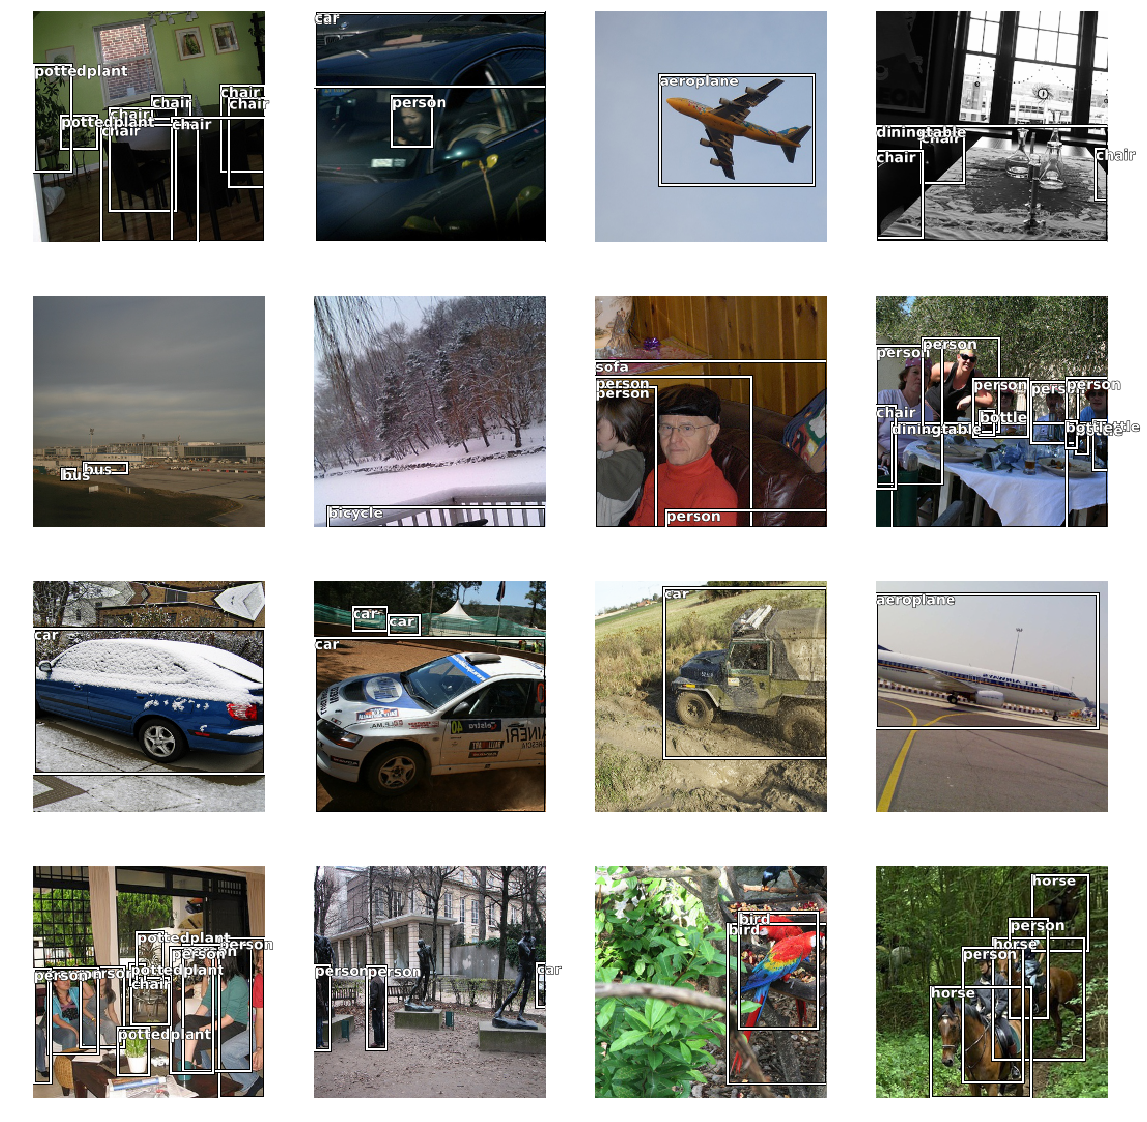

In [6]:
data.show_batch()

In [7]:
resnet = torchvision.models.resnet18(pretrained=True)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [15]:
im = data.train_ds[0][0].data.unsqueeze(0)
resnet_body = nn.Sequential(*(list(resnet.children())[:-2]))
out = resnet_body(im)
out.shape

torch.Size([1, 512, 7, 7])

In [24]:
num_classes = len(data.classes)
grid_sz = 7 - 2
anc_sizes = torch.tensor([
    [2, 0.5],
    [0.5, 2],
    [1, 1]])
grid = ObjectDetectionGrid(grid_sz, anc_sizes, num_classes)
model = ObjectDetectionModel(grid)

In [25]:
def class_accuracy(out, gt_boxes, gt_classes):
  labels = model.grid.decode(out)[1]
  return accuracy(labels, gt_classes)

def box_error(out, gt_boxes, gt_classes):
  boxes = model.grid.decode(out)[0]
  return mean_absolute_error(boxes, gt_boxes)

def loss(out, gt_boxes, gt_classes):
    gt = model.grid.encode(gt_boxes, gt_classes)
    box_loss, class_loss = model.grid.compute_losses(out, gt)
    return box_loss + class_loss

In [26]:
learn = Learner(data, model, loss_func=loss, metrics=[class_accuracy, box_error])
model.freeze_body()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


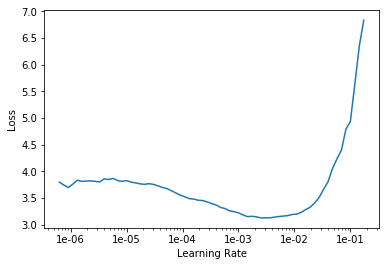

In [27]:
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.fit(1, 1e-2)


AssertionError: Expected output and target to have the same number of elements but got 4800 and 640.

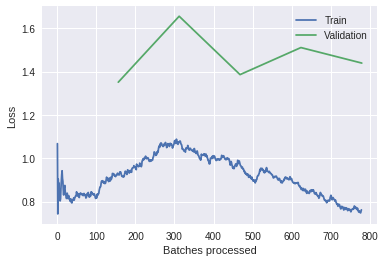

In [0]:
learn.recorder.plot_losses()

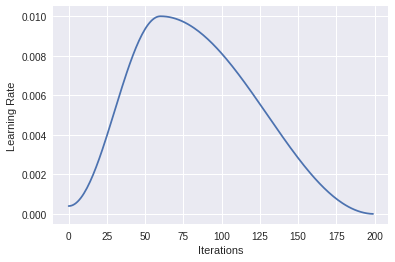

In [0]:
learn.recorder.plot_lr()

In [0]:
model.unfreeze()
learn.fit_one_cycle(1, 1e-3)

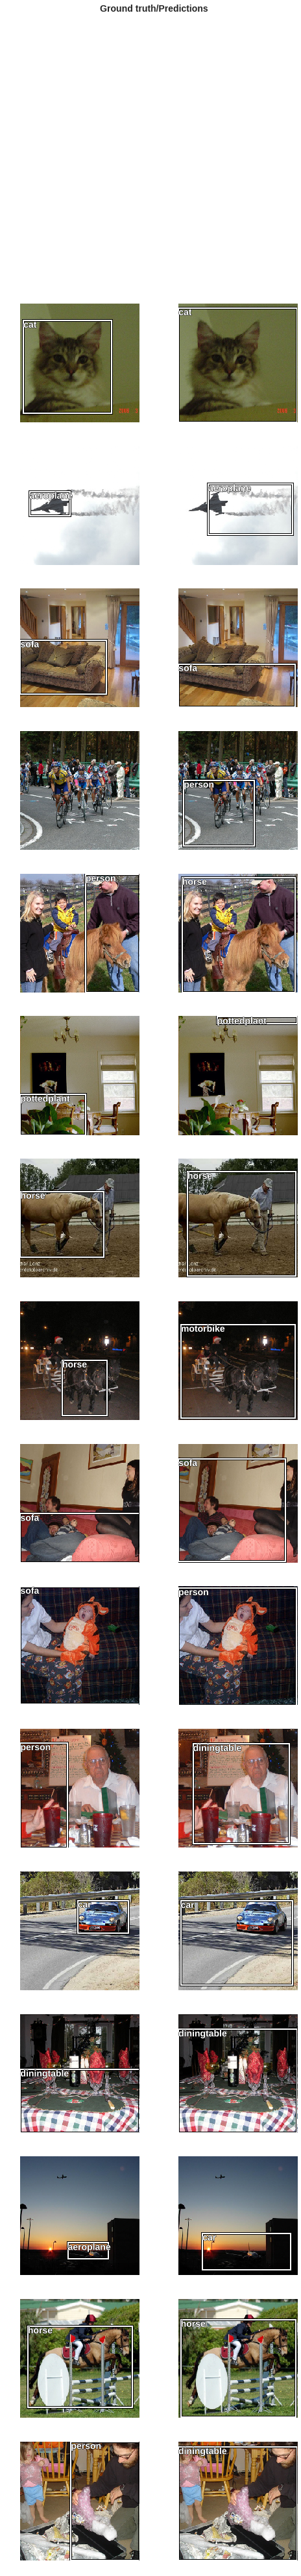

In [0]:
learn.show_results(rows=16)

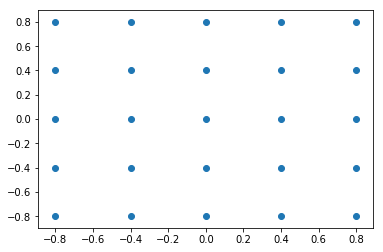

In [6]:
# make anchors
grid_size = 5
img_size = 2.0
cell_size = img_size / grid_size
# proportion of cell_size to use for anchor
# anchor_sizes = [(2, 2), (3, 1), (1, 3)]
# anchor_sizes = [(4, 4), (6, 2), (2, 6)]
anchor_sizes = [(4, 4), (6, 2), (2, 6), (2, 2), (3, 1), (1, 3)]

centers = []
for x in np.arange(cell_size/2.0 - 1, img_size - 1, cell_size):
  for y in np.arange(cell_size/2.0 - 1, img_size - 1, cell_size):
    centers.append((x, y))


# centers = [(0, 0)]
anchors = []
for x, y in centers:
  for h, w in anchor_sizes:
    a_h = cell_size * h
    a_w = cell_size * w
    a = [y-a_h/2, x-a_w/2, y+a_h/2, x+a_w/2]
    a = np.clip(a, -1, 1)
    anchors.append(a)

plt.scatter([c[0] for c in centers], [c[1] for c in centers])
plt.grid(False)
plt.show()


In [7]:
from shapely import geometry

def box2shapely(box):
  ymin, xmin, ymax, xmax = box
  return geometry.box(xmin, ymin, xmax, ymax)

def iou(a, b):
  i = a.intersection(b)
  u = a.union(b)
  return i.area / u.area

shp_anchors = [box2shapely(a) for a in anchors]

ModuleNotFoundError: No module named 'shapely'

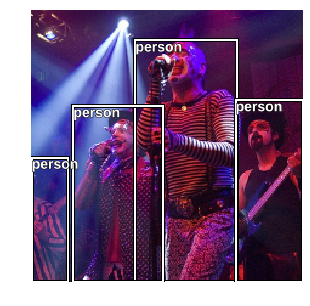

In [140]:
im_ind = 31
x, y = data.valid_ds[im_ind]
boxes, classes = y.data
shp_boxes = [box2shapely(b) for b in boxes]

bb = ImageBBox.create(*x.size, anchors, scale=False)
# x.show(y=bb, figsize=(5, 5))
x.show(y=y, figsize=(5, 5))

In [141]:
iou_thresh = 0.5

box2anchors = {}
for box_ind, b in enumerate(shp_boxes):
  ious = np.array([iou(a, b) for a in shp_anchors])
  match_inds = np.argwhere(ious > iou_thresh)[:, 0]
  box2anchors[box_ind] = match_inds
  
print(box2anchors)

{0: array([67, 73, 79, 85]), 1: array([133, 139, 141, 142, 145]), 2: array([18, 24, 43, 49, 51, 52, 55]), 3: array([22, 28])}


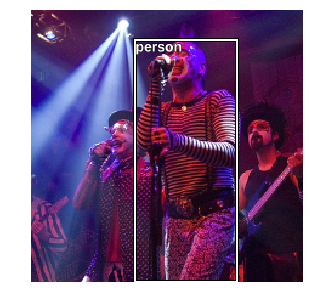

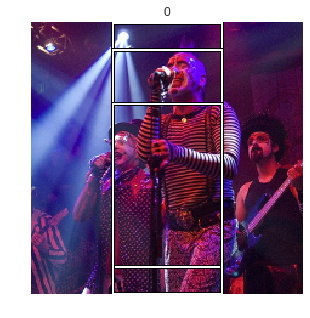

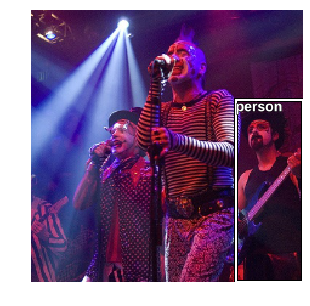

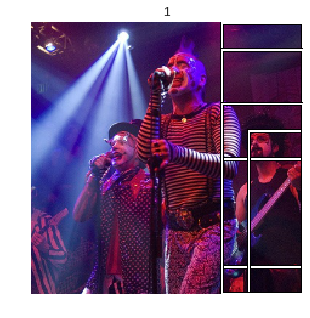

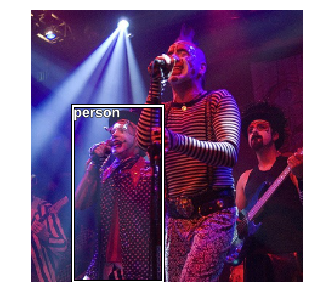

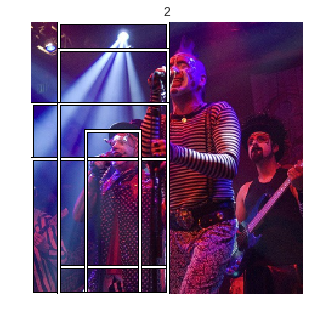

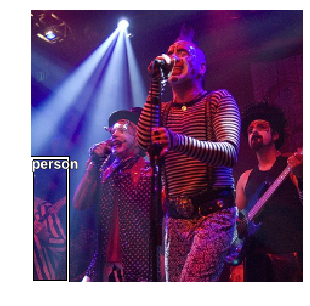

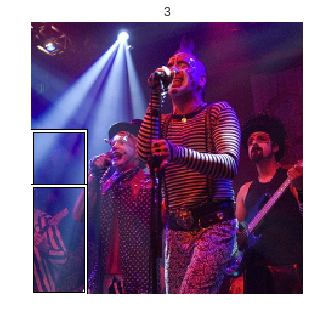

In [142]:
for box_ind, anchor_inds in box2anchors.items():
  match_anchors = [anchors[i] for i in anchor_inds]

  y_part = ImageBBox.create(
    *x.size, y.data[0][box_ind:box_ind+1], labels=y.data[1][box_ind:box_ind+1], 
    classes=data.classes, scale=False)
  x.show(y=y_part, figsize=(5, 5))
  
  anchor_bb = ImageBBox.create(*x.size, match_anchors, scale=False) if match_anchors else None
  x.show(y=anchor_bb, figsize=(5, 5), title=str(box_ind))
